### Assignment 6: DBSCAN, OPTICS, BIRCH Clustering

### Objective:
To build Unsupervised model like DBSCAN, OPTICS, BIRCH Clustering to discover hidden and interesting patterns inside the data. Comparing the results of all, Visualizing and interpreting the formed clusters.

### Fatal Police Shooting Data

**About dataset**\
The dataset consists of following columns
1. **id**                         : unqiue identifier of each victim
2. **name**                       : name of a victim
3. **date**                       : date on fatal shooting 
4. **manner_of_death**            : manner of death classification
    * Shot
    * Shot and Tasered
5. **armed**                      : indicates that the victim was armed with some sort of implement that a police officer believed could inflict harm
    * undetermined: it is not known whether or not the victim had a weapon
    * unknown: the victim was armed, but it is not known what the object was
    * unarmed: the victim was not armed
6. **age**                        : age of victim
7. **gender**                     : the gender of the victim. The Post identifies victims by the gender they identify with if reports indicate that it differs from their biological sex.
    * M: Male
    * F: Female
    * None: Unknown
8. **race**                       : race of victim
    * W: White, non-Hispanic
    * B: Black, non-Hispanic
    * A: Asian
    * N: Native American
    * H: Hispanic
    * O: Other
    * None: unknown
9. **city**                       : the municipality where the fatal shooting took place. Note that in some cases this field may contain a county name if a more specific municipality is unavailable or unknown.
10. **state**                     : two-letter postal code abbreviation
11. **signs_of_mental_illness**   : News reports have indicated the victim had a history of mental health issues, expressed suicidal intentions or was experiencing mental distress at the time of the shooting.
12. **threat_level**              : These would include incidents where officers or others were shot at, threatened with a gun, attacked with other weapons or physical force, etc. The attack category is meant to flag the highest level of threat. The other and undetermined categories represent all remaining cases. Other includes many incidents where officers or others faced significant threats. 
13. **flee**                      : News reports have indicated the victim was moving away from officers
    * Foot
    * Car
    * Not fleeing
14. **body_camera**               : News reports have indicated an officer was wearing a body camera and it may have recorded some portion of the incident.

### Import all neccessary libraries

In [47]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to perform DBSCAN, OPTICS, BIRCH
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import Birch

import copy

import warnings
warnings.filterwarnings('ignore')

In [48]:
police = pd.read_csv("fatal-police-shootings-data.csv")
police.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [49]:
police.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4478 entries, 0 to 4477
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       4478 non-null   int64  
 1   name                     4478 non-null   object 
 2   date                     4478 non-null   object 
 3   manner_of_death          4478 non-null   object 
 4   armed                    4230 non-null   object 
 5   age                      4309 non-null   float64
 6   gender                   4473 non-null   object 
 7   race                     4105 non-null   object 
 8   city                     4478 non-null   object 
 9   state                    4478 non-null   object 
 10  signs_of_mental_illness  4478 non-null   bool   
 11  threat_level             4478 non-null   object 
 12  flee                     4299 non-null   object 
 13  body_camera              4478 non-null   bool   
dtypes: bool(2), float64(1), 

### Let's pre-process the data

In [50]:
# Remove all the rows that contain missing value
police = police.dropna()

In [51]:
police.columns

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera'],
      dtype='object')

In [52]:
# Drop redundant features
police = police.drop(['id','date','name','city','state'],axis=1)


# We take a copy of our source data.
df = copy.deepcopy(police)
df.head()




,manner_of_death,armed,age,gender,race,signs_of_mental_illness,threat_level,flee,body_camera
0,shot,gun,53.0,M,A,True,attack,Not fleeing,False
1,shot,gun,47.0,M,W,False,attack,Not fleeing,False
2,shot and Tasered,unarmed,23.0,M,H,False,other,Not fleeing,False
3,shot,toy weapon,32.0,M,W,True,attack,Not fleeing,False
4,shot,nail gun,39.0,M,H,False,attack,Not fleeing,False


In [53]:
# Convert categorical variables to numeric
for feature in df.columns: # Loop through all columns in the dataframe
    if df[feature].dtype == 'object': # Only apply for columns with categorical strings
        df[feature] = pd.Categorical(df[feature]).codes # Replace strings with an integer

In [54]:
# Convert Boolean features to numeric
df = pd.get_dummies(df, columns=['signs_of_mental_illness','body_camera'],dtype=int)

In [55]:
df.head()

,manner_of_death,armed,age,gender,race,threat_level,flee,signs_of_mental_illness_False,signs_of_mental_illness_True,body_camera_False,body_camera_True
0,0,30,53.0,1,0,0,2,0,1,1,0
1,0,30,47.0,1,5,0,2,1,0,1,0
2,1,75,23.0,1,2,1,2,1,0,1,0
3,0,74,32.0,1,5,0,2,0,1,1,0
4,0,53,39.0,1,2,0,2,1,0,1,0


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3663 entries, 0 to 4477
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   manner_of_death                3663 non-null   int8   
 1   armed                          3663 non-null   int8   
 2   age                            3663 non-null   float64
 3   gender                         3663 non-null   int8   
 4   race                           3663 non-null   int8   
 5   threat_level                   3663 non-null   int8   
 6   flee                           3663 non-null   int8   
 7   signs_of_mental_illness_False  3663 non-null   int32  
 8   signs_of_mental_illness_True   3663 non-null   int32  
 9   body_camera_False              3663 non-null   int32  
 10  body_camera_True               3663 non-null   int32  
dtypes: float64(1), int32(4), int8(6)
memory usage: 135.9 KB


### DBSCAN 

#### DBSCAN Clustering (where DBSCAN is short for Density-Based Spatial Clustering of Applications with Noise) involves finding high-density areas in the domain and expanding those areas of the feature space around them as clusters.

**It is implemented via the DBSCAN class and the main configuration to tune is the “eps” and “min_samples” hyperparameters.**
- Epsilon (Eps): This is the least distance required for two points to be termed as a neighbor.
- Minsamples: This refers to the minimum number of points needed to construct a cluster. We consider MinPoints as a threshold for considering a cluster as a cluster.

### Question 1  ( 4 Marks )
**Perform DBSCAN with hyperparameters eps=0.1 and min_samples=9. Fit and predict your pre processed data to the DBSCAN model. Also display and visualize the number of clusters using countplot.**

In [57]:
#Build DBSCAN Clustering model from sklearn.cluster library with eps=0.1 and min_samples=9.
DBSCAN_model = DBSCAN(eps=0.1, min_samples=9)

#Fit and predict on your preprocessed data.
DP = DBSCAN_model.fit(df)
DP_df = DBSCAN_model.fit_predict(df)

#Adding the Clusters feature to the original dataframe.
df["Clusters"] = DP_df

In [58]:
#Use appropriate method from numpy library to find the unique count of clusters.
clusters = np.unique(DP_df)
len(clusters)

24

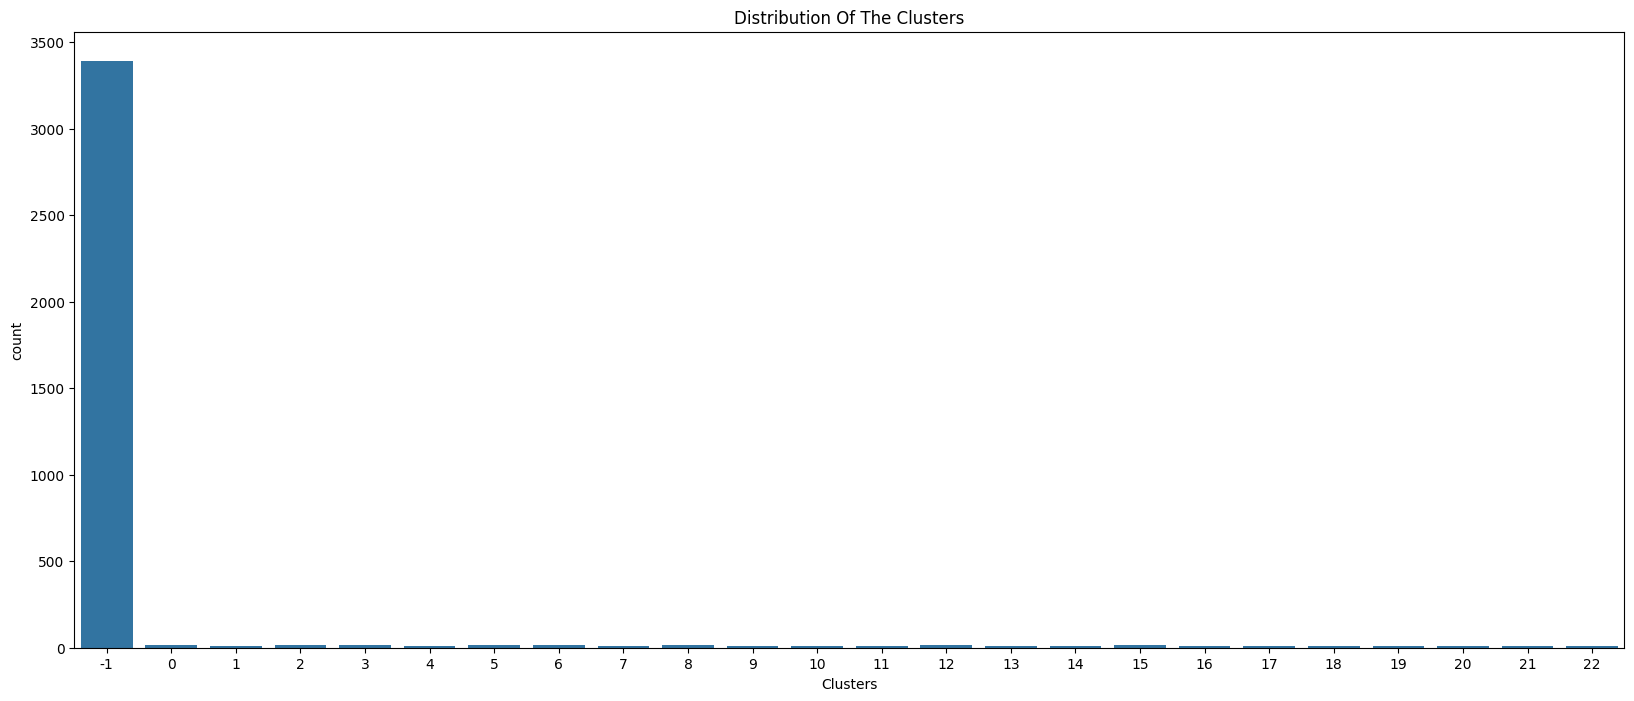

In [59]:
#Use count plot from seaborn library to visualize the distribution of clusters.
plt.figure(figsize=(20, 8))
pl = sns.countplot(x="Clusters", data=df)
pl.set_title("Distribution Of The Clusters")
plt.show()

### OPTICS
**OPTICS clustering (where OPTICS is short for Ordering Points To Identify the Clustering Structure) is a modified version of DBSCAN described above.**

### Question 2 ( 4 Marks )
**Perform OPTICS with hyperparameters eps=0.1 and min_samples=9. Fit and predict your pre processed data to the OPTICS model. Also display and visualize the number of clusters using countplot.**

In [60]:
#Build OPTICS Clustering model from sklearn.cluster library with eps=0.1 and min_samples=9.
OPTICS_model = OPTICS(eps=0.1, min_samples=9)

#Fit and predict on your preprocessed data.
OP = OPTICS_model.fit(df)
OP_df = OPTICS_model.fit_predict(df)

#Adding the Clusters feature to the original dataframe.
df["Clusters"] = OP_df

In [61]:
#Use appropriate method from numpy library to find the unique count of clusters.
clusters = np.unique(OP_df)
len(clusters)

56

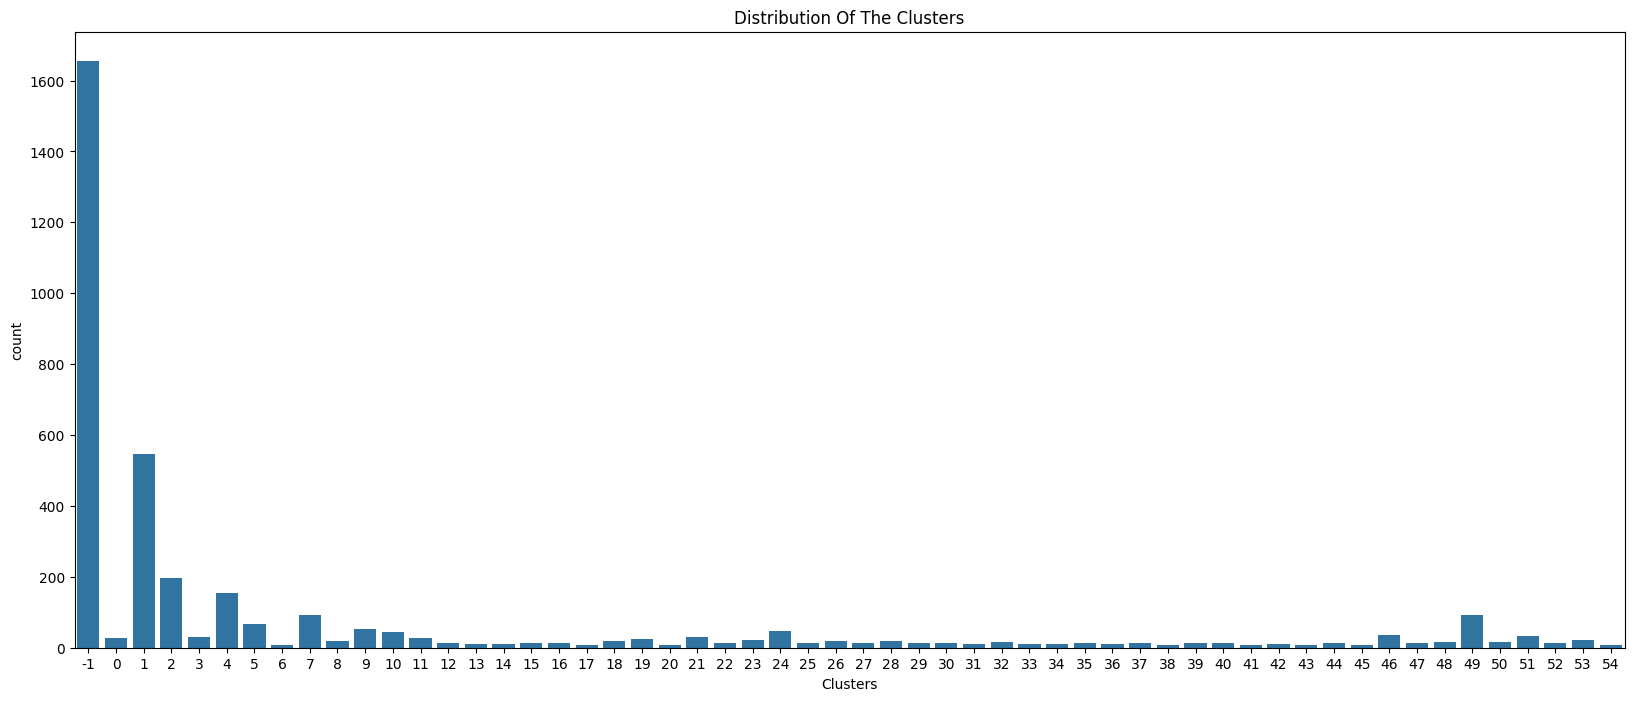

In [62]:
#Use count plot from seaborn library to visualize the distribution of clusters.
plt.figure(figsize=(20, 8))
sns.countplot(x="Clusters", data=df)
plt.title("Distribution Of The Clusters")
plt.show()

### BIRCH
**BIRCH Clustering (BIRCH is short for Balanced Iterative Reducing and Clustering using
Hierarchies) involves constructing a tree structure from which cluster centroids are extracted.**

### Question 3 ( 2 Mark )
**Perform Birch on 3 clusters and fit your pre processed data to it. Visualize the clusters using count plot.**

In [63]:
sc = Birch(n_clusters=3)
sc.fit(df)
labels = sc.labels_

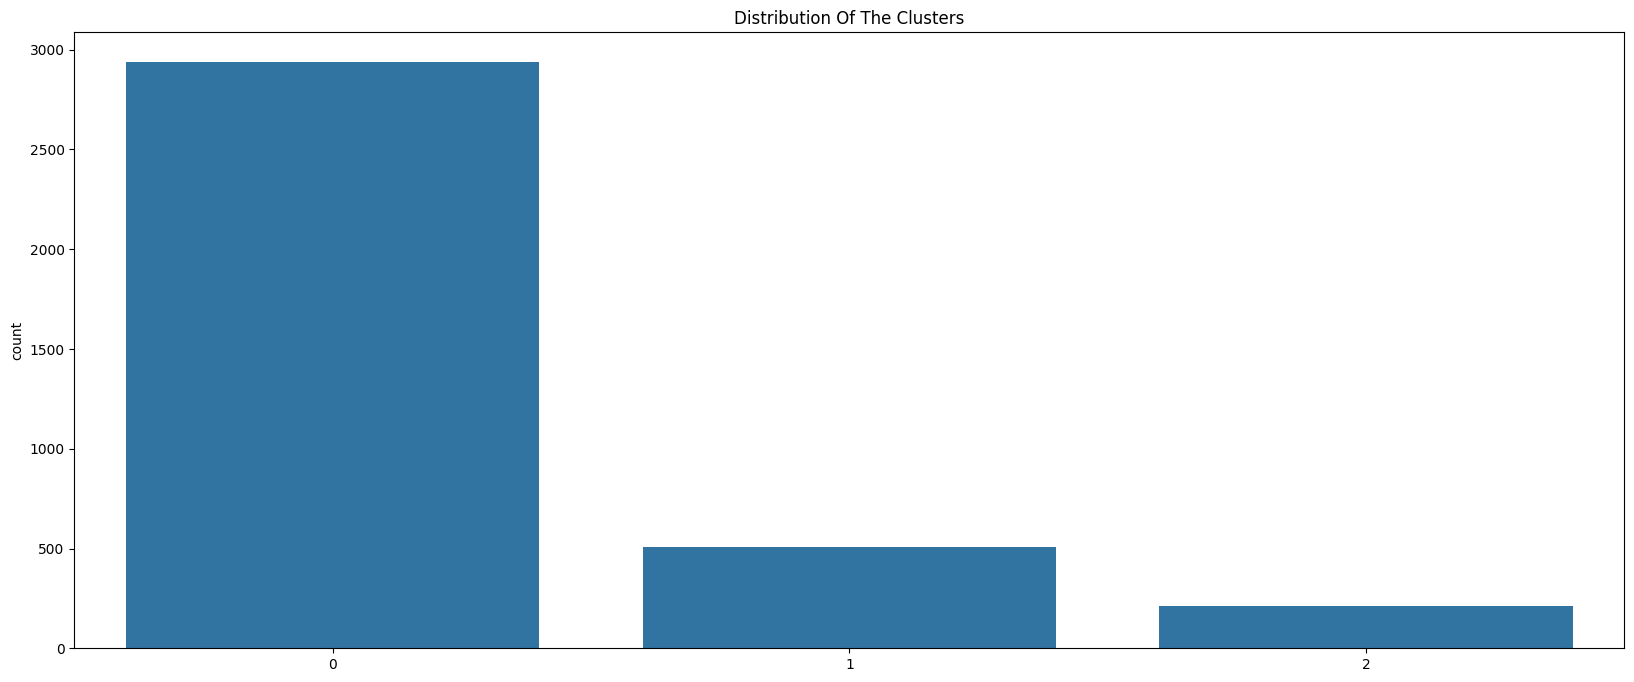

In [64]:
#Plotting countplot of clusters
plt.figure(figsize=(20, 8))
pl = sns.countplot(x=labels)
pl.set_title("Distribution Of The Clusters")
plt.show()